# Invoice Standardization Agentic Workflow

<a href="https://colab.research.google.com/github/run-llama/llamacloud-demo/blob/main/examples/document_workflows/invoice_payments/invoice_standardization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates a workflow for unit conversion workflow system that helps organizations standardize and normalize units across their supply chain and inventory management systems.

### Why is this important?

In modern supply chains, businesses deal with multiple suppliers who may use different unit
measurements for the same products. For example:
- Supplier A might deliver in pallets
- Supplier B might deliver in boxes
- Supplier C might deliver in containers

This creates several challenges:
1. Difficulty in comparing prices across suppliers
2. Complexity in inventory management
3. Risk of errors in order fulfillment
4. Challenges in standardizing reporting

### The Challenge: Understanding Our Documents

To demonstrate this common business problem, we work with two key documents:

1. **Sample Invoice Dataset**: (`invoice.pdf`)
- A complex invoice with multiple suppliers and varied units:
  - Global Pack Solutions (using pallets, boxes, containers)
  - Chemical Solutions Inc. (using drums and totes)
  - Textile Industries Ltd. (using rolls and bundles)
- Shows how different suppliers use different units of measurement for their products
- Contains pricing information and quantities in non-standardized formats
- Dated January 28, 2024
- Total of 7 line items across 3 suppliers

2. **Unit Conversion Reference Table** `unit_conversion_reference_table.pdf`
- A comprehensive reference document containing conversion rules across multiple categories:
  - Packaging Units (e.g., box → unit, pallet → unit)
  - Weight-Based Units (e.g., kilogram → gram)
  - Volume-Based Units (e.g., liter → milliliter)
  - Dimension-Based Units (e.g., meter → centimeter)
  - Industry-Specific Units (e.g., drums, totes, bundles)
- Each category includes:
  - Base unit for standardization
  - Alternative units with conversion rates
  - Notes and industry-specific information

### Common Business Challenges

How do you standardize and compare quantities when:
- Different suppliers use different units
- Same products might be packaged differently
- Need to aggregate totals across different unit types
- Need to maintain accurate conversion rates
- Industry-specific units need special handling

### How does this solution help?

This workflow system:
1. Automatically detects and extracts units from invoices
2. Converts all measurements to standardized base units
3. Maintains conversion accuracy using predefined conversion tables
4. Generates standardized reports for better decision making

### The Workflow Process

The system solves these challenges through a structured workflow:
1. Parsing both documents
2. Extracting structured data
3. Applying the correct conversions
4. Producing standardized totals
5. Maintaining supplier-specific breakdowns

For example, from the invoice we can see that "5 pallets" needs to be converted to base units using the conversion rate "1:2400" from the reference table, resulting in 12,000 units.

### Business Impact

This standardization is crucial for:
- Inventory management
- Cost comparison across suppliers
- Accurate order fulfillment
- Consistent reporting
- Supply chain optimization

### Implementation

The workflow uses:
- Document parsing with LlamaParse
- Extraction using OpenAI LLM.
- Structured output in JSON format

### Files Used

**Input Files:**

`invoice.pdf:` Contains the sample invoice data with multiple suppliers and varied units.

`unit_conversion_reference_table.pdf:` Contains the conversion rules across different categories.

**Output File:**

`standardized_invoice_report.pdf:` Final report with standardized units across all suppliers.

You can inspect the output file to check the standardization across suppliers and verify the conversions.

### Installation

We need to install `llama-index` for orchestration and `llama-parse` for parsing the documents.

In [ ]:
!pip install llama-index llama-parse

### Set API Keys

Here we setup `LLAMA_CLOUD_API_KEY` to use LlamaParse and `OPENAI_API_KEY` to use OpenAI LLM.

In [2]:
import os

os.environ['LLAMA_CLOUD_API_KEY'] = 'llx-..' # Get your API Key from https://cloud.llamaindex.ai/
os.environ['OPENAI_API_KEY'] = 'sk-...' # Get your API Key from https://platform.openai.com/

### Imports

In [3]:
from typing import List, Optional, Dict
from pydantic import BaseModel, Field
from llama_index.core.workflow import (
    Event,
    StartEvent,
    StopEvent,
    Context,
    Workflow,
    step,
)
from llama_index.llms.openai import OpenAI
from llama_index.core.prompts import ChatPromptTemplate
from llama_index.core.llms import ChatMessage, MessageRole
from llama_parse import LlamaParse
import json
from pathlib import Path
import nest_asyncio

# Enable nested asyncio for Jupyter notebook support
nest_asyncio.apply()

### Data Models

Here we define the Pydantic models which useful for extraction of necessary details from the document and data validation.

#### Pydantic Models For Unit Conversion

`UnitConversion:` Represents a single unit conversion rule with its metadata.

`ConversionTableCategory:` Groups related conversions under a specific category (e.g., "Packaging Units" or "Weight-Based Units").

`ConversionTables:` Master collection of all conversion categories and their rules.

`LineItem`: Represents a single item in an invoice with its quantity and pricing details.

`SupplierSection`: Groups line items by supplier within an invoice.

#### Pydantic Models for Invoice Processing

`Invoice`: Complete representation of an invoice with all its sections and items.

`StandardizedLineItem`: Represents a line item that has been converted to standard units. It captures both the original item details and its standardized measurements.

`StandardizedInvoice`: Represents the entire invoice after all items have been standardized:

In [4]:
# Pydantic Models for Unit Conversion
class UnitConversion(BaseModel):
    """Represents a single unit conversion rule (e.g., box to units)"""
    base_unit: str = Field(..., description="Base unit for conversion")
    alternative_unit: str = Field(..., description="Alternative unit")
    conversion_rate: str = Field(..., description="Conversion rate as string (e.g., '1:24')")
    notes: Optional[str] = Field(None, description="Additional notes")
    industry: Optional[str] = Field(None, description="Specific industry if applicable")

    def get_conversion_multiplier(self) -> float:
        """Calculate numeric multiplier from conversion rate string (e.g., '1:24' returns 24.0)"""
        try:
            num1, num2 = map(float, self.conversion_rate.split(':'))
            return num2 / num1
        except (ValueError, ZeroDivisionError) as e:
            raise ValueError(f"Invalid conversion rate: {self.conversion_rate}") from e

class ConversionTableCategory(BaseModel):
    """Groups related conversions under a category (e.g., Packaging Units)"""
    category_name: str = Field(..., description="Name of the category")
    base_unit: str = Field(..., description="Standard base unit")
    conversions: List[UnitConversion] = Field(..., description="List of conversions")

class ConversionTables(BaseModel):
    """Master collection of all unit conversion categories"""
    categories: List[ConversionTableCategory] = Field(..., description="List of categories")

# Pydantic Models for Invoice Processing
class LineItem(BaseModel):
    """Single item in an invoice with quantity and pricing details"""
    description: str = Field(..., description="Item description")
    quantity: float = Field(..., description="Original quantity")
    unit: str = Field(..., description="Original unit")
    unit_price: float = Field(..., description="Price per unit")
    total_price: float = Field(..., description="Total price")

class SupplierSection(BaseModel):
    """Groups line items by supplier within an invoice"""
    supplier: str = Field(..., description="Supplier name")
    line_items: List[LineItem] = Field(..., description="List of line items for this supplier")

class Invoice(BaseModel):
    """Complete invoice with multiple supplier sections"""
    invoice_id: str = Field(..., description="Invoice identifier")
    date: str = Field(..., description="Invoice date")
    supplier_sections: List[SupplierSection] = Field(..., description="List of supplier sections")

class StandardizedLineItem(BaseModel):
    """Line item with quantities converted to standard units"""
    supplier: str = Field(..., description="Supplier name")
    original_item: LineItem = Field(..., description="Original line item")
    standardized_quantity: float = Field(..., description="Converted quantity")
    standardized_unit: str = Field(..., description="Standard unit")
    conversion_rate: float = Field(..., description="Used conversion rate")
    conversion_category: str = Field(..., description="Conversion category")

class StandardizedInvoice(BaseModel):
    """Invoice with all quantities converted to standard units and calculated totals"""
    invoice_id: str = Field(..., description="Invoice identifier")
    date: str = Field(..., description="Invoice date")
    line_items: List[StandardizedLineItem] = Field(..., description="Standardized items")
    total_standard_units: Dict[str, float] = Field(..., description="Totals by unit")
    supplier_totals: Dict[str, Dict[str, float]] = Field(..., description="Totals by supplier and unit")

### Workflow Events

Here we define event classes define the different states and transitions in our workflow. They help orchestrate the conversion process and maintain state throughout.

`ParsedConversionTablesEvent:` Triggered after successfully parsing the conversion reference tables (e.g., converting '1 box = 24 units')

`ParsedInvoiceEvent:` Triggered after successfully extracting structured data from an invoice document.

`StandardizedLineItemEvent:` Request to convert a single item's units (e.g., convert '5 pallets' to standard units)

`StandardizedLineItemResultEvent:` Contains the result of converting a single item's units (e.g., '5 pallets = 12000 units').

`LogEvent:` Simple event for logging workflow progress and status updates.


In [5]:
class ParsedConversionTablesEvent(Event):
    """Triggered after successfully parsing the conversion reference tables (e.g., converting '1 box = 24 units')"""
    conversion_tables: ConversionTables

class ParsedInvoiceEvent(Event):
    """Triggered after successfully extracting structured data from an invoice document"""
    invoice: Invoice

class StandardizedLineItemEvent(Event):
    """Request to convert a single item's units (e.g., convert '5 pallets' to standard units)"""
    supplier: str
    line_item: LineItem
    conversion_tables: Dict

class StandardizedLineItemResultEvent(Event):
    """Contains the result of converting a single item's units (e.g., '5 pallets = 12000 units')"""
    result: StandardizedLineItem

class LogEvent(Event):
    """Simple event for logging workflow progress and status updates"""
    msg: str
    delta: bool = False

### Prompts

Here we define prompts for extraction of information from Unit conversion and invoice documents.



In [6]:
# Prompts for Unit Conversion

SYSTEM_PROMPT_TABLES = """You are a unit conversion expert. Extract structured conversion data from tables."""

USER_PROMPT_TABLES = """Extract the conversion tables data into structured format following these rules:
1. Group conversions by their categories (Packaging Units, Weight-Based Units, etc.)
2. For each conversion:
   - Identify the base unit and alternative unit
   - Extract the conversion rate in the format "X:Y"
   - Include any notes or industry-specific information

Here is the conversion tables document:

{table_text}"""

# Prompts for Invoice 
SYSTEM_PROMPT_INVOICE = """You are an invoice parsing expert. Extract structured data from invoices."""

USER_PROMPT_INVOICE = """Extract the invoice data into structured format including:
- Invoice ID (assign a unique identifier if not present)
- Date
- Multiple supplier sections, each containing:
  - Supplier name
  - Line items with quantities, units, and prices

Here is the invoice:

{invoice_text}"""

### Main Workflow Implementation

Here we implement the workflow for invoice standardization.

**a) Parse Conversion Tables (First Step)**

Triggered by: Initial StartEvent.
Reads conversion table PDF.
Uses LLM to extract structured data.
Outputs: ParsedConversionTablesEvent containing conversion rules.

**b) Prepare Conversion Dictionary**

Triggered by: ParsedConversionTablesEvent
Converts parsed tables into lookup dictionary
Stores dictionary in context for later use

**c) Parse Invoice**

Triggered by: ParsedConversionTablesEvent
Reads invoice PDF
Uses AI to extract structured invoice data
Outputs: ParsedInvoiceEvent with structured invoice data

**d) Dispatch Standardization**

Triggered by: ParsedInvoiceEvent
Splits invoice into individual line items
For each line item: Creates StandardizedLineItemEvent

**e) Standardize Line Items**

Triggered by: StandardizedLineItemEvent
Converts one line item's units to standard units
Outputs: StandardizedLineItemResultEvent with converted quantities

**f) Generate Final Output**

Triggered by: All StandardizedLineItemResultEvents
Collects all standardized items
Calculates totals by supplier and unit
Creates final StandardizedInvoice
Saves to JSON file
Outputs: StopEvent with final results

The event flow looks like this:

```
StartEvent 
  → ParsedConversionTablesEvent 
    → ParsedInvoiceEvent 
      → Multiple StandardizedLineItemEvents 
        → Multiple StandardizedLineItemResultEvents 
          → StopEvent
```

Throughout the workflow:

1. LogEvents are emitted for progress tracking
2. Context (ctx) is used to store and share data between steps
3. Events carry data and trigger next steps
4. Each step is asynchronous (@step decorator)
5. Error handling and validation occur at each step

In [7]:
class InvoiceStandardizationWorkflow(Workflow):
    def __init__(
        self,
        parser: LlamaParse,
        llm: OpenAI,
        output_dir: str = "data_out",
        **kwargs,
    ) -> None:
        super().__init__(**kwargs)
        self.parser = parser
        self.llm = llm
        
        # Create output directory
        out_path = Path(output_dir)
        if not out_path.exists():
            out_path.mkdir(parents=True, exist_ok=True)
        self.output_dir = out_path

    @step
    async def parse_conversion_tables(
        self, ctx: Context, ev: StartEvent
    ) -> ParsedConversionTablesEvent:
        """Parse conversion tables PDF"""
        await ctx.set("conversion_tables_path", ev.conversion_tables_path)
        await ctx.set("invoice_path", ev.invoice_path)

        if self._verbose:
            ctx.write_event_to_stream(LogEvent(msg=">> Parsing conversion tables"))

        parsed_docs = await self.parser.aload_data(ev.conversion_tables_path)
        table_text = "\n".join([d.get_content() for d in parsed_docs])

        prompt = ChatPromptTemplate(
            message_templates=[
                ChatMessage(role=MessageRole.SYSTEM, content=SYSTEM_PROMPT_TABLES),
                ChatMessage(role=MessageRole.USER, content=USER_PROMPT_TABLES)
            ]
        )

        conversion_tables = await self.llm.astructured_predict(
            ConversionTables,
            prompt,
            table_text=table_text
        )

        return ParsedConversionTablesEvent(conversion_tables=conversion_tables)

    @step
    async def prepare_conversion_dict(
        self, ctx: Context, ev: ParsedConversionTablesEvent
    ) -> None:
        """Convert tables to lookup dictionary"""
        conversion_dict = {}
        for category in ev.conversion_tables.categories:
            category_dict = {
                "base_unit": category.base_unit,
                "conversions": {}
            }
            
            for conversion in category.conversions:
                multiplier = conversion.get_conversion_multiplier()
                conv_entry = {
                    "rate": multiplier,
                    "base_unit": category.base_unit,
                    "notes": conversion.notes,
                    "category": category.category_name
                }
                if conversion.industry:
                    conv_entry["industry"] = conversion.industry
                
                category_dict["conversions"][conversion.alternative_unit.lower()] = conv_entry
                
            conversion_dict[category.category_name] = category_dict

        await ctx.set("conversion_dict", conversion_dict)

    @step
    async def parse_invoice(
        self, ctx: Context, ev: ParsedConversionTablesEvent
    ) -> ParsedInvoiceEvent:
        """Parse invoice with multiple supplier sections"""
        if self._verbose:
            ctx.write_event_to_stream(LogEvent(msg=">> Parsing invoice"))

        invoice_path = await ctx.get("invoice_path")
        parsed_docs = await self.parser.aload_data(invoice_path)
        invoice_text = "\n".join([d.get_content() for d in parsed_docs])

        prompt = ChatPromptTemplate(
            message_templates=[
                ChatMessage(role=MessageRole.SYSTEM, content=SYSTEM_PROMPT_INVOICE),
                ChatMessage(role=MessageRole.USER, content=USER_PROMPT_INVOICE)
            ]
        )

        invoice = await self.llm.astructured_predict(
            Invoice,
            prompt,
            invoice_text=invoice_text
        )

        return ParsedInvoiceEvent(invoice=invoice)

    @step
    async def dispatch_standardization(
        self, ctx: Context, ev: ParsedInvoiceEvent
    ) -> StandardizedLineItemEvent:
        """Dispatch line items from all suppliers for standardization"""
        conversion_dict = await ctx.get("conversion_dict")
        total_items = sum(len(section.line_items) for section in ev.invoice.supplier_sections)
        await ctx.set("num_items", total_items)
        await ctx.set("invoice_metadata", {
            "invoice_id": ev.invoice.invoice_id,
            "date": ev.invoice.date,
        })
        
        for section in ev.invoice.supplier_sections:
            for item in section.line_items:
                ctx.send_event(StandardizedLineItemEvent(
                    supplier=section.supplier,
                    line_item=item,
                    conversion_tables=conversion_dict
                ))

    @step
    async def standardize_line_item(
        self, ctx: Context, ev: StandardizedLineItemEvent
    ) -> StandardizedLineItemResultEvent:
        """Standardize a single line item with supplier information"""
        unit = ev.line_item.unit.lower()
        conversion_found = False
        
        for category, data in ev.conversion_tables.items():
            if unit in data["conversions"]:
                conv_info = data["conversions"][unit]
                standardized_quantity = ev.line_item.quantity * conv_info["rate"]
                
                result = StandardizedLineItem(
                    supplier=ev.supplier,
                    original_item=ev.line_item,
                    standardized_quantity=standardized_quantity,
                    standardized_unit=conv_info["base_unit"],
                    conversion_rate=conv_info["rate"],
                    conversion_category=category
                )
                conversion_found = True
                break
        
        if not conversion_found:
            if self._verbose:
                ctx.write_event_to_stream(
                    LogEvent(msg=f">> Warning: No conversion found for unit {unit}")
                )
            result = StandardizedLineItem(
                supplier=ev.supplier,
                original_item=ev.line_item,
                standardized_quantity=ev.line_item.quantity,
                standardized_unit=ev.line_item.unit,
                conversion_rate=1.0,
                conversion_category="unknown"
            )

        return StandardizedLineItemResultEvent(result=result)

    @step
    async def generate_final_output(
        self, ctx: Context, ev: StandardizedLineItemResultEvent
    ) -> StopEvent:
        """Generate final standardized invoice with supplier-specific totals"""
        num_items = await ctx.get("num_items")
        events = ctx.collect_events(ev, [StandardizedLineItemResultEvent] * num_items)
        if events is None:
            return

        standardized_items = [e.result for e in events]
        invoice_metadata = await ctx.get("invoice_metadata")
        
        # Calculate overall totals by standard unit
        totals = {}
        # Calculate totals by supplier and unit
        supplier_totals = {}
        
        for item in standardized_items:
            unit = item.standardized_unit
            supplier = item.supplier
            
            # Update overall totals
            if unit not in totals:
                totals[unit] = 0
            totals[unit] += item.standardized_quantity
            
            # Update supplier-specific totals
            if supplier not in supplier_totals:
                supplier_totals[supplier] = {}
            if unit not in supplier_totals[supplier]:
                supplier_totals[supplier][unit] = 0
            supplier_totals[supplier][unit] += item.standardized_quantity

        standardized_invoice = StandardizedInvoice(
            **invoice_metadata,
            line_items=standardized_items,
            total_standard_units=totals,
            supplier_totals=supplier_totals
        )

        # Save output
        output_path = self.output_dir / f"{invoice_metadata['invoice_id']}_standardized.json"
        with open(output_path, "w") as f:
            f.write(standardized_invoice.model_dump_json(indent=2))

        return StopEvent(result=standardized_invoice)


### Create workflow

Here we initialize LLM, parser and create the workflow.

In [8]:
# Initialize parser and llm
parser = LlamaParse(result_type="markdown")
llm = OpenAI(model="gpt-4")

workflow = InvoiceStandardizationWorkflow(
    parser=parser,
    llm=llm,
    verbose=True,
    timeout=1000
)

### Visualize workflow

In [9]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(InvoiceStandardizationWorkflow, filename="invoice_standardization_workflow.html")

<class 'NoneType'>
<class '__main__.StandardizedLineItemEvent'>
<class 'llama_index.core.workflow.events.StopEvent'>
<class '__main__.ParsedConversionTablesEvent'>
<class '__main__.ParsedInvoiceEvent'>
<class 'NoneType'>
<class '__main__.StandardizedLineItemResultEvent'>
invoice_standardization_workflow.html


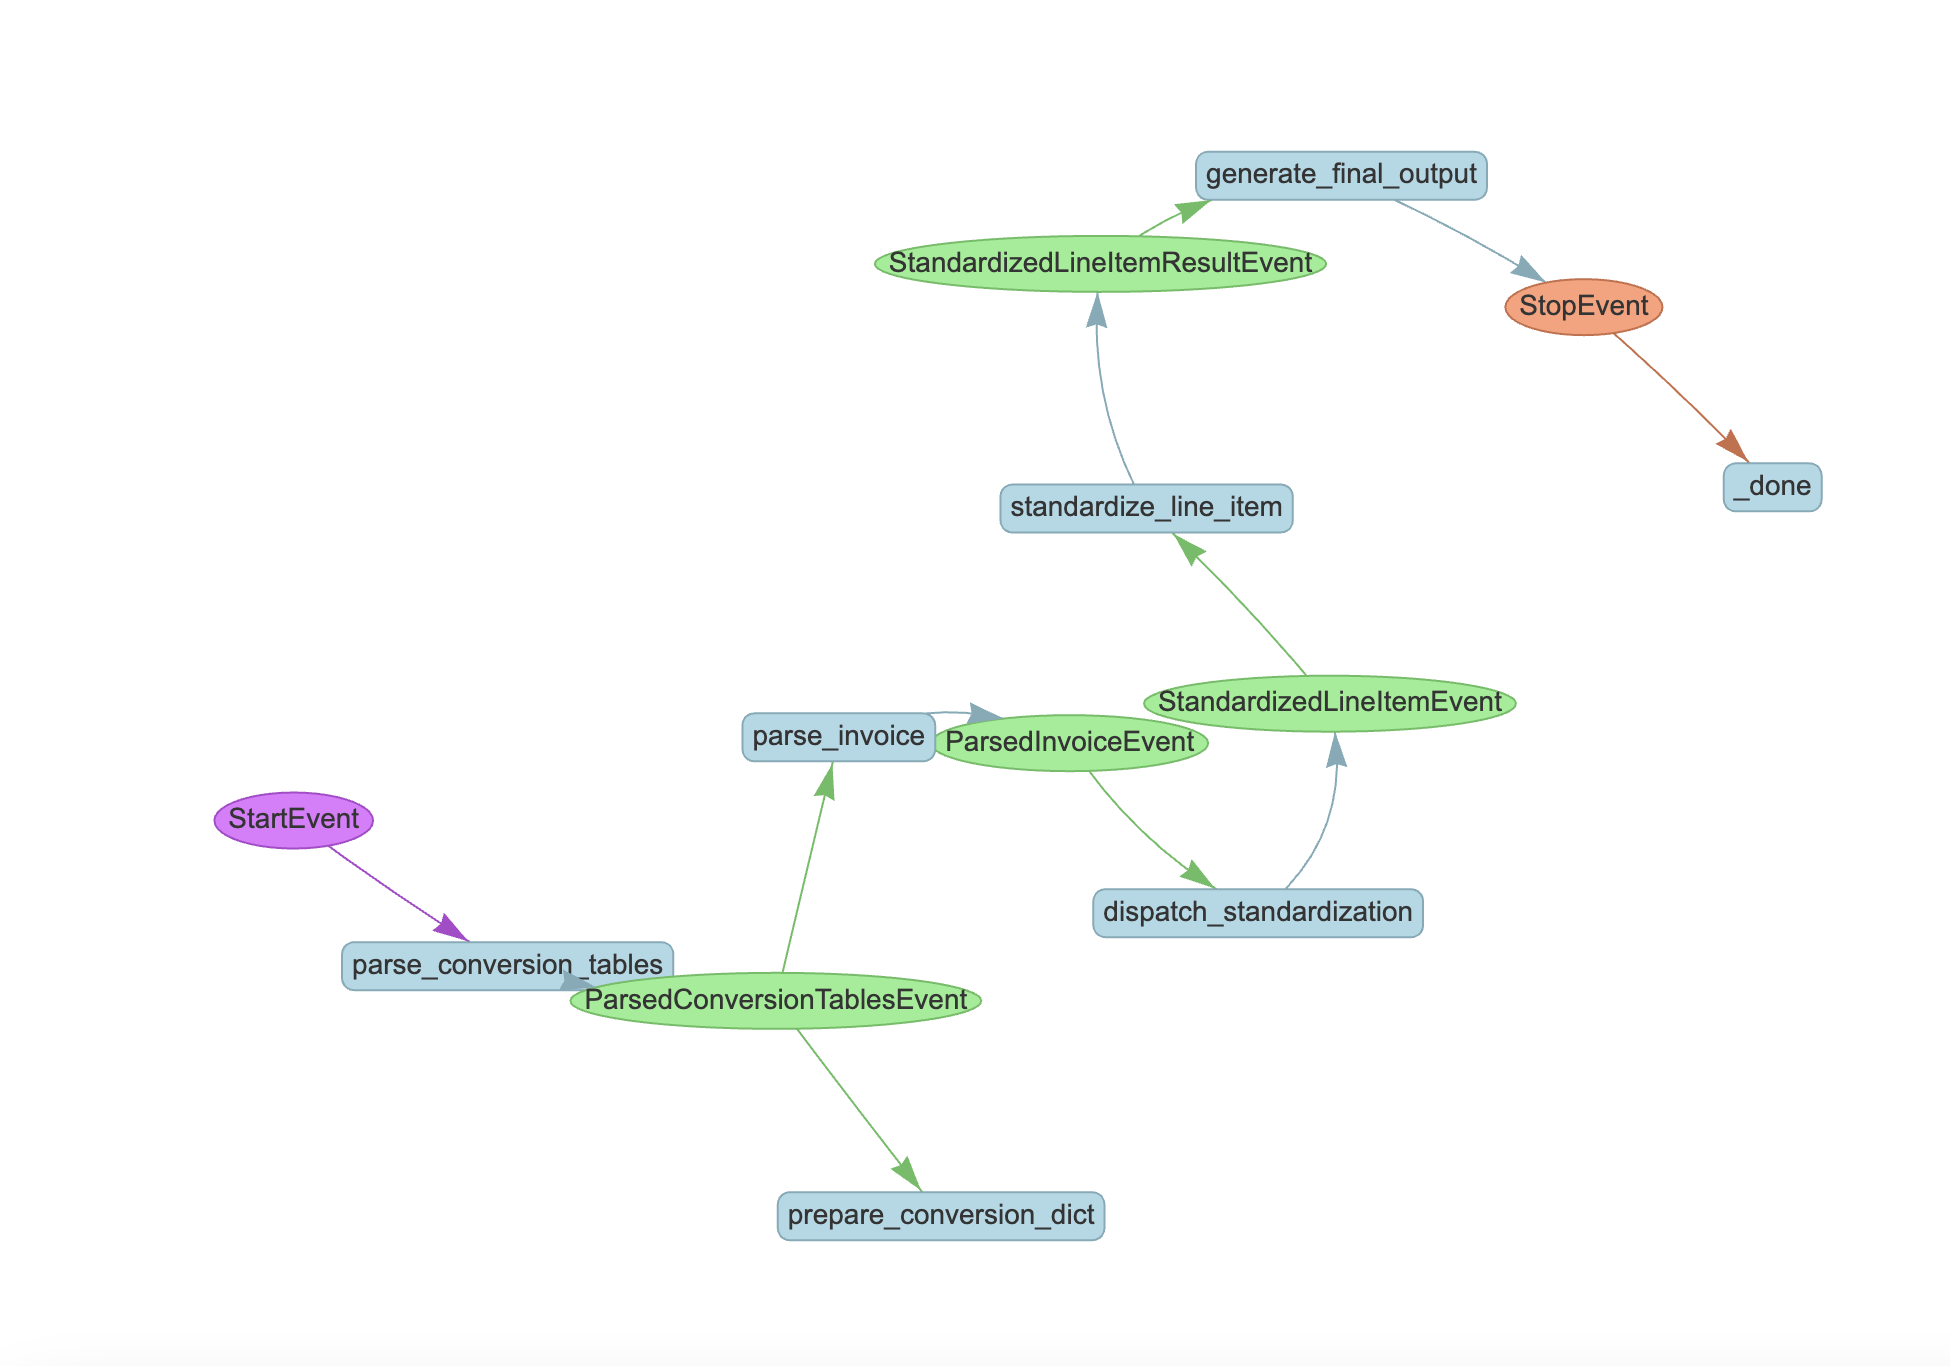

In [14]:
from IPython.display import Image, display

display(Image('invoice_standardization_workflow.png', width=500, height=300))

### Run the workflow

Here we run the workflow and check the final result

In [10]:
# Run workflow
handler = workflow.run(
    conversion_tables_path="./unit_conversion_reference_table.pdf",
    invoice_path="./invoice.pdf"
)

# Process events
async for event in handler.stream_events():
    if isinstance(event, LogEvent):
        print(event.msg)

# Get final result
result = await handler

Running step parse_conversion_tables
>> Parsing conversion tables
Started parsing the file under job_id 505977ab-9dff-4e42-ae01-240fb21968ee
Step parse_conversion_tables produced event ParsedConversionTablesEvent
Running step parse_invoice
Running step prepare_conversion_dict
Step prepare_conversion_dict produced no event
>> Parsing invoice
Started parsing the file under job_id 905fe6fb-3c37-417c-8b58-27130a94e819
Step parse_invoice produced event ParsedInvoiceEvent
Running step dispatch_standardization
Step dispatch_standardization produced no event
Running step standardize_line_item
Step standardize_line_item produced event StandardizedLineItemResultEvent
Running step standardize_line_item
Step standardize_line_item produced event StandardizedLineItemResultEvent
Running step standardize_line_item
Step standardize_line_item produced event StandardizedLineItemResultEvent
Running step standardize_line_item
Step standardize_line_item produced event StandardizedLineItemResultEvent
Running

In [11]:
print("\nStandardized Invoice:")
print(json.dumps(result.model_dump(), indent=2))


Standardized Invoice:
{
  "invoice_id": "INV-001",
  "date": "2024-01-28",
  "line_items": [
    {
      "supplier": "Global Pack Solutions",
      "original_item": {
        "description": "5 pallets of Widget A (Product ID: W-101)",
        "quantity": 5.0,
        "unit": "pallet",
        "unit_price": 150.0,
        "total_price": 750.0
      },
      "standardized_quantity": 12000.0,
      "standardized_unit": "unit",
      "conversion_rate": 2400.0,
      "conversion_category": "Packaging Units"
    },
    {
      "supplier": "Global Pack Solutions",
      "original_item": {
        "description": "12 boxes of Component B (Product ID: C-202)",
        "quantity": 12.0,
        "unit": "box",
        "unit_price": 45.0,
        "total_price": 540.0
      },
      "standardized_quantity": 288.0,
      "standardized_unit": "unit",
      "conversion_rate": 24.0,
      "conversion_category": "Packaging Units"
    },
    {
      "supplier": "Global Pack Solutions",
      "original_it

### Generate Standardized Invoice Report

Here we generate the standardized invoice report based on the result obtained.

In [12]:
from docx import Document
from docx.enum.text import WD_ALIGN_PARAGRAPH
import json

def create_invoice_report(data, output_filename="standardized_invoice_report.docx"):
    """
    Create a formatted DOCX report from standardized invoice data.
    
    Args:
        data (dict): Standardized invoice data
        output_filename (str): Name of output file
    """
    doc = Document()
    
    # Add title
    title = doc.add_heading('Standardized Invoice Report', 0)
    title.alignment = WD_ALIGN_PARAGRAPH.CENTER
    
    # Add basic invoice information
    doc.add_paragraph()
    p = doc.add_paragraph()
    p.add_run('Invoice Details\n').bold = True
    p.add_run(f'Invoice ID: {data["invoice_id"]}\n')
    p.add_run(f'Date: {data["date"]}\n')
    
    # Add summary section
    doc.add_paragraph()
    doc.add_heading('Summary', level=1)
    p = doc.add_paragraph()
    p.add_run('Total Standard Units: ').bold = True
    p.add_run(f'{data["total_standard_units"]["unit"]:,.0f} units\n')
    
    # Add supplier totals
    doc.add_heading('Supplier Totals', level=1)
    table = doc.add_table(rows=1, cols=2)
    table.style = 'Table Grid'
    
    # Add header row
    header_cells = table.rows[0].cells
    header_cells[0].text = 'Supplier'
    header_cells[1].text = 'Total Units'
    
    # Add supplier data
    for supplier, totals in data["supplier_totals"].items():
        row_cells = table.add_row().cells
        row_cells[0].text = supplier
        row_cells[1].text = f'{totals["unit"]:,.0f}'
    
    # Add detailed line items
    doc.add_paragraph()
    doc.add_heading('Detailed Line Items', level=1)
    
    # Create table for line items
    table = doc.add_table(rows=1, cols=7)
    table.style = 'Table Grid'
    
    # Add header row
    header_cells = table.rows[0].cells
    headers = ['Supplier', 'Description', 'Original Qty', 'Original Unit', 
              'Standardized Qty', 'Unit Price', 'Total Price']
    for i, header in enumerate(headers):
        header_cells[i].text = header
        header_cells[i].paragraphs[0].runs[0].bold = True
    
    # Add line items
    for item in data["line_items"]:
        row_cells = table.add_row().cells
        row_cells[0].text = item["supplier"]
        row_cells[1].text = item["original_item"]["description"]
        row_cells[2].text = f'{item["original_item"]["quantity"]:,.1f}'
        row_cells[3].text = item["original_item"]["unit"]
        row_cells[4].text = f'{item["standardized_quantity"]:,.1f}'
        row_cells[5].text = f'${item["original_item"]["unit_price"]:,.2f}'
        row_cells[6].text = f'${item["original_item"]["total_price"]:,.2f}'
    
    # Add conversion information
    doc.add_paragraph()
    doc.add_heading('Conversion Details', level=1)
    table = doc.add_table(rows=1, cols=4)
    table.style = 'Table Grid'
    
    # Add header row
    header_cells = table.rows[0].cells
    headers = ['Original Unit', 'Conversion Rate', 'Standard Unit', 'Category']
    for i, header in enumerate(headers):
        header_cells[i].text = header
        header_cells[i].paragraphs[0].runs[0].bold = True
    
    # Add unique conversions
    added_units = set()
    for item in data["line_items"]:
        unit = item["original_item"]["unit"]
        if unit not in added_units:
            row_cells = table.add_row().cells
            row_cells[0].text = unit
            row_cells[1].text = f'1:{item["conversion_rate"]}'
            row_cells[2].text = item["standardized_unit"]
            row_cells[3].text = item["conversion_category"]
            added_units.add(unit)
    
    # Add footer with timestamp
    doc.add_paragraph()
    footer = doc.add_paragraph()
    footer.alignment = WD_ALIGN_PARAGRAPH.RIGHT
    
    # Save the document
    doc.save(output_filename)
    return output_filename

In [13]:
output_file = create_invoice_report(data = result.model_dump(), 
                                    output_filename="standardized_invoice_report.docx")